# Implement tensor operations with PyTorch einsum: from basic to self-attention

[PyTorch einsum](https://pytorch.org/docs/stable/generated/torch.einsum.html) is a helpful and practical tool in any machine learning engineer or researcher's toolkit. The syntax is pithy and self-documenting. This makes it both a great thinking tool and also easier coding and debugging. One can easily visualize the shapes of the input and output tensors in any deep learning model. 

In this article, we provide code using einsum and visualizations for several tensor operations, thinking of these operations as tensor compressions. These operations are commonly used in deep learning models. We start from simple and familiar operations like _rowsum_ that serve as building blocks. And gradually build up to defining multi-head attention, a core component of large language models. Where applicable I compare with more common ways of implementing these operations in PyTorch and why I think einsum is easier. See these [visualizations](https://www.tensors.net/tutorial-1) and the [original proposal](https://nlp.seas.harvard.edu/NamedTensor) for more discussion.

A note on self-attention with einsum implementation: Like everything in PyTorch, there are mutiple ways to implement self-attention. llama3's [open-sourced attention](https://github.com/meta-llama/llama3/blob/14aab0428d3ec3a9596f1dea06d9c564f9c0e35f/llama/model.py#L90) for training LLMs on multiple GPUs in parallel uses modules like [ColumnParallelLinear](https://github.com/facebookresearch/fairscale/blob/5f484b3545f27eddb19d970fbe1d361b9c5f2b07/fairscale/nn/model_parallel/layers.py#L218) instead of Linear, but the underlying math remains the same. See also, [this efficient implementation](https://github.com/facebookresearch/xformers/blob/95f085abc3ba8cfaa2527250b8e274a95b10f7fe/xformers/components/attention/core.py#L208). With this einsum-based implementation of self-attention, I focus on readability and exposition. 

## Einsum Syntax with Transpose

Let's look at transpose to make the basic syntax clear. 

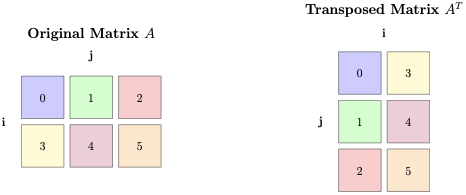

The first argument to [einsum](https://pytorch.org/docs/stable/generated/torch.einsum.html) is an _equation_ string describing the operation. And the second argument are the operands, the tensors on which to perform the operation. 

Consider _transpose_ operation $a'$ given by $torch.einsum('ij->ji', a)$. The equation for transposing matrix $a$ is $ij->ji$. The left hand side (LHS) of the equation labels each dimension of each operand with a subscript. i.e. the LHS tells us $i$ specifies the row dimension and $j$ the column. The right hand side (RHS) specifies which subscripts are part of the output and in what order. RHS tells us we want the subscript order to change; we want $j$ rows and $i$ columns.

An alternate interpretation of the equation is: input tensor $a$ has shape $(i,j)$, and we want a result tensor of shape $(j,i)$. 

More generally, LHS is a comma-separated string of operand subscripts. RHS is a single string of subscripts specifying the output dimensions and their order. Note the actual alphabets for subscripts are irrelevant. This same equation could be $bs->sb$, as long as we are consistent on LHS and RHS.

And, here is the code:

In [64]:
import torch
import torch.nn.functional as F
import math

a = torch.arange(6).reshape(2, 3)
a

tensor([[0, 1, 2],
        [3, 4, 5]])

In [65]:
torch.einsum('ij->ji', a)

tensor([[0, 3],
        [1, 4],
        [2, 5]])

## Rowsum

More interesting applications of einsum are when we want to sum along one or more dimensions. Let's look at rowsum, wherein we want to sum all rows of a matrix.

In the einsum notation, any subscript that is absent in the RHS is summed out. Let's consider rowsum, with the equation $ij->j$. Note $i$ is not on the RHS. This tells us to sum across dimension $i$. Since the RHS has $j$, it tells us we want output a tensor with shape $(j)$

Another way to interpret the einsum notation is to think of tensor operations as compressions. e.g., summing all rows can be thought of as compressing the tensor to a single row. 

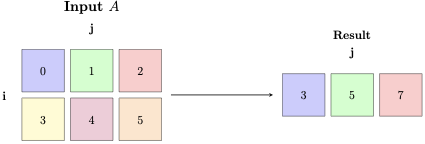

In [66]:
torch.einsum('ij->j', a)

tensor([3, 5, 7])

In [67]:
torch.sum(a, dim=0)

tensor([3, 5, 7])

## Colsum

Similarly, colsum $ij->i$ is summing all cols, or compressing all columns to a single column. We sum along dimension $j$ (missing on the RHS) to get a vector of length $i$.

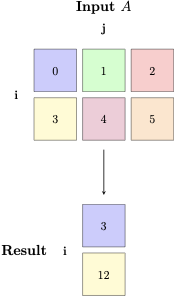

In [68]:
torch.einsum('ij->i', a)

tensor([ 3, 12])

In [69]:
torch.sum(a, dim=1)

tensor([ 3, 12])

## Sum

If we want to sum all elements of the tensor to a single scalar, the RHS has no subscripts $ij->$. That means we compress or sum along both rows and columns.

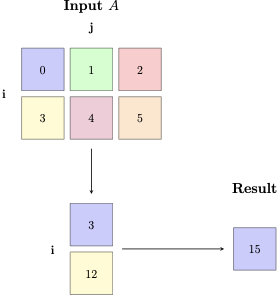

In [70]:
torch.einsum('ij->', a)

tensor(15)

## Matrix vector multiplication

More often we want to do things with multiple tensors. Let's consider a matrix vector multiplication with equation $ij,j->i$. Given input $a$ of shape $(i,j)$ and $b$ of shape $j$, we want output of shape $(i)$.

The index missing in $ij, j -> i$ on the RHS is $j$. This means we sum across $j$. 

Let's think of this in terms on tensor compressions to visualize better:
<ol>
<li>Weight all columns of $a$ with elements of $b$, each column $i$ of $a$ is multiplied by $b[i]$.</li>
<li>Sum/compress all columns of intermediate result.</li>
</ol>

The advantage of thinking in this way is it provides a useful abstraction for tensors of higher dimensions. And einsum provides a straightforward way to translate this thinking explicitly into code.

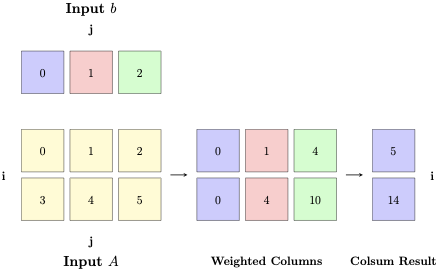

In [71]:
b = torch.arange(3)
b

tensor([0, 1, 2])

In [72]:
a*b.view(1, -1)

tensor([[ 0,  1,  4],
        [ 0,  4, 10]])

In [73]:
torch.einsum('ij,j->i', a, b)

tensor([ 5, 14])

## Matrix-Matrix multiplication

Again, the index missing in $ij, jk -> ik$ on the RHS is $j$. This means we sum across $j$. 

To help visualize using tensor compressions, do $ij,j->i$ as we did in matrix vector multiplication, $k$ times for each column $k$ of $C$. 

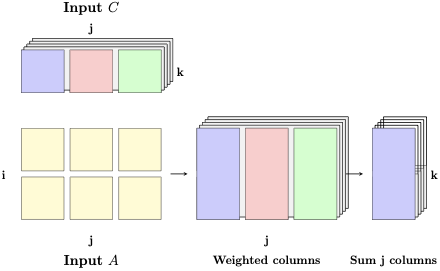

In [74]:
c = torch.arange(12).reshape(3, 4)
c.shape

torch.Size([3, 4])

In [75]:
torch.einsum('ij, jk -> ik', [a, c])

tensor([[20, 23, 26, 29],
        [56, 68, 80, 92]])

## Dot product

In [76]:
torch.einsum('j,j->',[b,b])

tensor(5)

## softmax($w^T M_t$)

It is not obvious from reading this single line below what probs shape is. One has to rely either on comments or look at the input tensor dimensions, determine what the output shape is, and then remember it. Instead with einsum, it is clear the distribution is across j output nodes.

In [77]:
w = torch.randn(5)
M_t = torch.randn(5, 7)
probs = F.softmax(w.T.matmul(M_t), dim=0) 

#einsum implementation
probs_e = F.softmax(torch.einsum("i,ij->j",[w,M_t]), dim=0)

## $W h$ -  matrix vector multiplication for a batch of vectors

Caveat: The goal here is to show equivalence of outputs from einsum, Linear and matmul. In practice, one would rather use efficient library implementations like Linear, especially when used as part of a larger network. 

In [78]:
batch_size = 2
ip_dim = 3
op_dim = 5

h = torch.randn(batch_size, ip_dim) #a batch of 3-dimensional vectors
model = torch.nn.Linear(ip_dim, op_dim, bias = False)
w = model.weight
w.shape

torch.Size([5, 3])

In [79]:
batch_output = model(h)
batch_output

tensor([[ 0.8087, -0.5378, -0.1929,  0.0697, -0.0711],
        [-0.5292,  0.6672,  0.6847,  0.5311, -0.3524]], grad_fn=<MmBackward0>)

In [80]:
torch.matmul(h, w.T)

tensor([[ 0.8087, -0.5378, -0.1929,  0.0697, -0.0711],
        [-0.5292,  0.6672,  0.6847,  0.5311, -0.3524]], grad_fn=<MmBackward0>)

In [81]:
torch.einsum("ij,jk->ik", [h, w.T])

tensor([[ 0.8087, -0.5378, -0.1929,  0.0697, -0.0711],
        [-0.5292,  0.6672,  0.6847,  0.5311, -0.3524]],
       grad_fn=<ViewBackward0>)

# Self-attention using einsum

In the rest of this post, I implement self-attention as one would traditionally using transpose, matmul vs using einsum. For clarity, I focus on the fundamental operations and leave out masking as in decoder setup. 

## Linear projection for a batch of a sequence of vectors

Taking the above one step further. What if each "example" in our dataset is a sequence of items, and each item is a vector. e.g., In transformer-based NLP models, a sentence is a sequence of tokens (roughly) corresponding to subwords. Each token has a learned embedding. In self-attention mechanism, we first do a linear projection of the sequence of query, key and value token embeddings using $W_q$, $W_k$ and $W_v$ respectively. In this setting, ip_dim is the embedding dimension, and op_dim the head dimension.

In [82]:
seq_length = 6
sequence_data = torch.randn(batch_size, seq_length, ip_dim)
model(sequence_data);

In [83]:
Q = torch.einsum('ilj,jk->ilk',[sequence_data, w.T]) #output shape [batch size, seq length, op_dim] i.e., [2, 6, 5]
Q;

## Now consider the self-attention mechanism across multiple attention heads

We want to process the same sequence with multiple attention heads, each first doing a linear projection with corresponding weights. But why do n_head multiplications, when we could do one giant multiplication and use GPUs more efficiently? So, we do a _single_ linear projection into n_head*head_dim, i.e. $4*5=20$. Then, we view results spit across n_heads (4). This allows us to compute scores using softmax independently for each head.

In [84]:
n_heads= 4
head_dim = op_dim
wq = torch.nn.Linear(ip_dim, n_heads*op_dim, bias = False)

wk = torch.nn.Linear(ip_dim, n_heads*op_dim, bias = False)
wv = torch.nn.Linear(ip_dim, n_heads*op_dim, bias = False)
wo = torch.nn.Linear(n_heads*head_dim, ip_dim, bias = False)

In [85]:
xq = wq(sequence_data)
xq.shape

torch.Size([2, 6, 20])

In [86]:
xq = xq.view(batch_size, seq_length, n_heads, head_dim)
xq.shape

torch.Size([2, 6, 4, 5])

Similarly, compute keys and values.

In [87]:
keys = wk(sequence_data)
values = wv(sequence_data)

keys = keys.view(batch_size, seq_length, n_heads, head_dim)
values = values.view(batch_size, seq_length, n_heads, head_dim)

# Rearrange tensors so we compute one set of scores per attention-head
xq = xq.transpose(1, 2)  #(bs, n_heads, seqlen, head_dim)
keys = keys.transpose(1, 2)  #(bs, n_heads, seqlen, head_dim)
values = values.transpose(1, 2)  #(bs, n_heads, seqlen, head_dim)

Compute scores for all pairs of tokens in the sequence. For matmul between xq and keys to produce a seq_len*seq_len set of scores, we need to transpose keys so it has shape #(bs, n_heads, head_dim, seq_len)

In [88]:
scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(head_dim)
scores = F.softmax(scores.float(), dim=-1).type_as(xq)
scores.shape

torch.Size([2, 4, 6, 6])

Compute attention-weighted vector of the input sequence

In [89]:
output = torch.matmul(scores, values)  # (bs, n_heads, seqlen, head_dim)
output.shape

torch.Size([2, 4, 6, 5])

Concatenate outputs from multiple heads so we get an output tensor of shape (batch_size, seq_length, n_heads*head_dim) 

In [90]:
output = output.transpose(1, 2).contiguous().view(batch_size, seq_length, -1)
output.shape

torch.Size([2, 6, 20])

And one final linear projection

In [91]:
wo(output).shape

torch.Size([2, 6, 3])

## Einsum implementation of multi-head self-attention

The index that is missing in the output string is the one that is being compressed or summed over. So note in output_e computation below bhlj, bhjd -> bhld. Here we want to compress/sum over j. Perhaps it's easier to use the ellipsis notation, which brings the focus to lj, jd and now we can think again in 2 dimensions.

In [92]:
xqq = wq(sequence_data).view(batch_size, seq_length, n_heads, head_dim)
kk  = wk(sequence_data).view(batch_size, seq_length, n_heads, head_dim)
vv  = wv(sequence_data).view(batch_size, seq_length, n_heads, head_dim)

xqq = torch.einsum('blhd->bhld',[xqq])
kk  = torch.einsum('blhd->bhld',[kk])
vv  = torch.einsum('blhd->bhld', [vv])

scores_e = torch.einsum("bhid, bhjd -> bhij", [xqq, kk]) / math.sqrt(head_dim)
scores_e = F.softmax(scores_e.float(), dim =-1).type_as(xq)

print(f"Scores shape: {scores_e.shape}")
output_e = torch.einsum("bhlj,bhjd->bhld", scores_e, vv) 
output_e = torch.einsum("bhld->blhd", [output_e]).contiguous().view(batch_size, seq_length, -1)
output == output_e;

Scores shape: torch.Size([2, 4, 6, 6])


It is easier to see the crux of the operation with the ellipsis notation. We ignore the batch and head dimensions, and see we are summing across the j dimension.

In [93]:
output_ee = torch.einsum("...lj,...jd->...ld", scores_e, vv) 
output_ee = torch.einsum("bhld->blhd", [output_ee]).contiguous().view(batch_size, seq_length, -1)
output == output_ee;

In conclusion, einsum is a nifty tool to implement and visualize almost any tensor operation. An even more versatile tool is einops, that I plan to cover in a subsequent post.